In [3]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [4]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [93]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [94]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [104]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
start = time.time()
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)
print(f"Took: {time.time() - start} seconds")


0 4.666044606977243
1 2.9529080118533058
2 2.1640264563846703
3 2.890063823394537
4 0.3281049565250708
5 0.17303008992666408
6 0.11116562339628379
7 0.08193018572519377
8 0.06431983772564273
9 0.05266848992922654
10 0.044439115182079936
11 0.038341559627807345
12 0.03365562411300452
13 0.029949670822266822
14 0.026950160864273723
15 0.024475780296407432
16 0.02240182448917184
17 0.020639833473871213
18 0.019125391636964195
19 0.017810524413712083
Took: 0.16346049308776855 seconds


In [11]:
ypred

[Value(data=0.9582118055533463),
 Value(data=-0.9675572398114293),
 Value(data=-0.9185864804883725),
 Value(data=0.9130666616832106)]

In [12]:
import math

In [57]:
def stringify(nested_list):
    """
    Recursively convert all numbers in a nested list to strings with one decimal place.
    """
    if isinstance(nested_list, list):
        return '[' + ', '.join([stringify(item) for item in nested_list]) + ']'
    else:
        return f"{nested_list:.2f}"

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot_tensor(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ('record') node for it
        data_str = stringify(n.data)  # Use stringify for data
        grad_str = stringify(n.grad)  # Use stringify for grad
        dot.node(name=uid, label="{ %s | data %s | grad %s }" % (n.label, data_str, grad_str), shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # And connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [305]:
def tanh(x):
    return (math.exp(2*x) - 1) / (math.exp(2*x) + 1)

def tanh_prime(x):
    t = tanh(x)
    return 1 - t ** 2

def exp(x):
  return math.exp(x)

def zeros_matrix_like(matrix):
  return [[0 for _ in row] for row in matrix]

def ones_matrix_like(matrix):
  return [[1 for _ in row] for row in matrix]

def matrix_mul(matrix_a, matrix_b):
  rows_a = len(matrix_a)
  cols_a = len(matrix_a[0])
  rows_b = len(matrix_b)
  cols_b = len(matrix_b[0])

  if cols_a != rows_b:
      raise ValueError(f"The number of columns in the first matrix must be equal to the number of rows in the second matrix. Got cols_a {cols_a} and rows_b {rows_b}.")

  result = [[0 for _ in range(cols_b)] for _ in range(rows_a)]

  for i in range(rows_a):
      for j in range(cols_b):
          for k in range(cols_a):
              result[i][j] += matrix_a[i][k] * matrix_b[k][j]

  return result

def matrix_scalar_mul(scalar, matrix):
  return [[scalar * matrix[j][i] for i in range(len(matrix[0]))] for j in range(len(matrix))]

def matrix_add(matrix_a, matrix_b):
  if len(matrix_a) != len(matrix_b) or len(matrix_a[0]) != len(matrix_b[0]):
      raise ValueError("Matrices are not of the same dimensions.")

  result = [[matrix_a[i][j] + matrix_b[i][j] for j in range(len(matrix_a[0]))] for i in range(len(matrix_a))]
  return result

def matrix_transpose(matrix):
    return [[matrix[j][i] for j in range(len(matrix))] for i in range(len(matrix[0]))]

class Tensor:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data # Nested list
    self.grad = zeros_matrix_like(self.data)
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  @property
  def shape(self):
      # Initialize the shape list
      shape = []

      # Check the first element to determine if it's a list
      # and recursively find the dimensions
      element = self.data
      while isinstance(element, list):
          shape.append(len(element))
          element = element[0] if element else []

      return tuple(shape)

  def __repr__(self):
    return f"Tensor(data={self.data})"

  def __mul__(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)
    out = Tensor(matrix_mul(self.data, other.data), (self, other), '*')

    def _backward():
      self.grad = matrix_add(self.grad, matrix_mul(out.grad, matrix_transpose(other.data)))
      other.grad = matrix_add(other.grad, matrix_mul(matrix_transpose(self.data), out.grad))
    out._backward = _backward

    return out

  def __add__(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)
    out = Tensor(matrix_add(self.data, other.data), (self, other), '+')

    def _backward():
      self.grad = matrix_add(self.grad, out.grad)
      other.grad = matrix_add(other.grad, out.grad)
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __neg__(self): # -self
    return self * [[-1]]

  def __sub__(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def __pow__(self, power):

    # Apply power function element-wise
    result_data = [[x_ij ** power for x_ij in row] for row in self.data]
    out = Tensor(result_data, (self,), f'**{power}')

    def _backward():
        # Compute gradient with respect to the input tensor
        for i, row in enumerate(self.data):
            for j, val in enumerate(row):
                # Derivative of val**power is power * val**(power-1)
                self.grad[i][j] += power * (val ** (power - 1)) * out.grad[i][j]

    out._backward = _backward

    return out

  def __truediv__(self, other): # self / other
    return self * other**-1

  @property
  def T(self):
      """ Transpose the tensor. """
      transposed_data = matrix_transpose(self.data)
      return Tensor(transposed_data, _children=(self,), _op='transpose')


  def apply_func(self, func, func_prime):
    result_data = [[func(x_ij) for x_ij in row] for row in self.data]
    out = Tensor(result_data, (self,), func.__name__)
    def _backward():
      for i, row in enumerate(self.data):
          for j, _ in enumerate(row):
              self.grad[i][j] += func_prime(self.data[i][j]) * out.grad[i][j]
    out._backward = _backward
    return out

  def tanh(self):
    return self.apply_func(tanh, tanh_prime)

  def exp(self):
    return self.apply_func(exp, exp)

  def concat(self, other, axis=0):
    # This implementation assumes a simple case where tensors are 2D
    # and concatenated along the first dimension (axis=0)
    if axis != 0:
        raise NotImplementedError("Concatenation along this axis is not implemented.")

    concatenated_data = self.data + other.data

    out = Tensor(concatenated_data, _children=(self, other), _op='concat')

    def _backward():
      # Since concatenation is along axis=0, we split the gradient back to the original tensors
      # based on their data length
      self_len = len(self.data)
      self.grad = matrix_add(self.grad, out.grad[:self_len])
      other.grad = matrix_add(other.grad, out.grad[self_len:])

    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = ones_matrix_like(self.data)
    for node in reversed(topo):
      node._backward()



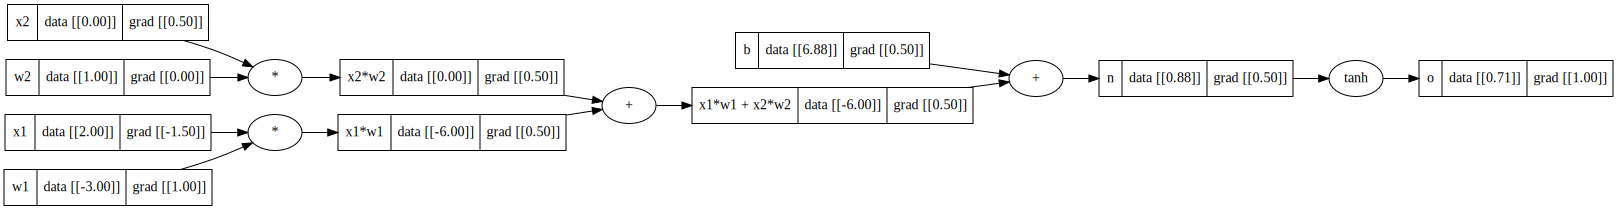

In [306]:
# inputs x1,x2
x1 = Tensor([[2.0]], label='x1')
x2 = Tensor([[0.0]], label='x2')
# weights w1,w2
w1 = Tensor([[-3.0]], label='w1')
w2 = Tensor([[1.0]], label='w2')
# bias of the neuron
b = Tensor([[6.8813735870195432]], label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot_tensor(o)

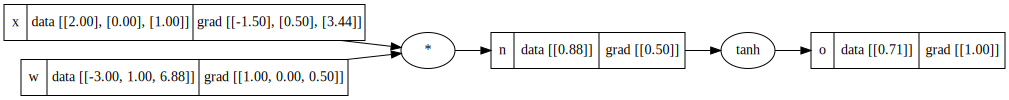

In [307]:
# inputs with bias
x = Tensor([[2.0],[0.0],[1.0]], label='x')
# weights w1,w2
w = Tensor([[-3.0,1.0,6.8813735870195432]], label='w')
n = w * x; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot_tensor(o)

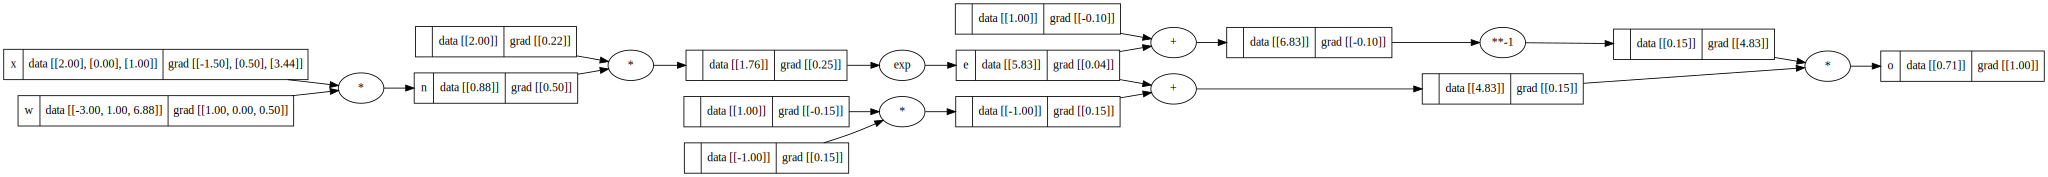

In [308]:
# inputs with bias
x = Tensor([[2.0],[0.0],[1.0]], label='x')
# weights w1,w2
w = Tensor([[-3.0,1.0,6.8813735870195432]], label='w')
n = w * x; n.label = 'n'
# ----
e = ([[2]]*n).exp(); e.label = 'e'
o = (e - [[1]]) / (e + [[1]])
# ----
o.label = 'o'
o.backward()
draw_dot_tensor(o)

In [309]:
x1 = Tensor([[2.0]])
x2 = Tensor([[0.0]])
w1 = Tensor([[-3.0]])
w2 = Tensor([[1.0]])
b = Tensor([[6.8813735870195432]])
n = x1*w1 + x2*w2 + b
o = n.tanh()

print(o.data)
o.backward()

print('---')
print('x2', x2.grad)
print('w2', w2.grad)
print('x1', x1.grad)
print('w1', w1.grad)

[[0.7071067811865476]]
---
x2 [[0.4999999999999999]]
w2 [[0.0]]
x1 [[-1.4999999999999996]]
w1 [[0.9999999999999998]]


In [310]:
class Layer2:

  def __init__(self, nin, nout, label=None):
    label = label if label is not None else f"Layer {nin} to {nout}"
    self.w = Tensor([[random.uniform(-1,1) for _ in range(nin + 1)] for _ in range(nout)], label=label)

  def __call__(self, x):
    bias = Tensor([[1]])
    x_with_bias = x.concat(bias, axis=0)
    outs = self.w * x_with_bias
    outs = outs.tanh()
    return outs

  def parameters(self):
    return [self.w]

class MLP2:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer2(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  @classmethod
  def from_mlp(cls, mlp):
    # Create an MLP2 instance without initializing layers
    instance = cls(nin=0, nouts=[])
    instance.layers = []  # Initialize layers as an empty list

    for mlp_layer in mlp.layers:
      nin = len(mlp_layer.neurons[0].w)  # Number of inputs is the number of weights in a neuron
      nout = len(mlp_layer.neurons)  # Number of outputs is the number of neurons
      # Initialize the weights matrix for Layer2 with zeros
      weights = [[0 for _ in range(nin + 1)] for _ in range(nout)]

      for i, neuron in enumerate(mlp_layer.neurons):
        for j, w in enumerate(neuron.w):
          weights[i][j] = w.data  # Assign weight
        weights[i][-1] = neuron.b.data  # Assign bias to the last column

      # Create Layer2 with the constructed weights matrix
      layer2 = Layer2(nin, nout)
      layer2.w = Tensor(weights)  # Assuming Tensor can be directly assigned
      layer2.w.label = f"Layer {nin} to {nout}"
      instance.layers.append(layer2)

    return instance

In [311]:
n = MLP(3, [4, 4, 1])
n2 = MLP2.from_mlp(n)

In [312]:
x = [2.0, 3.0, -1.0]
n(x)

Value(data=0.6913070002210265)

In [313]:
x2 = Tensor([[2.0], [3.0], [-1.0]])
n2(x2)

Tensor(data=[[0.6913070002210265]])

In [324]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
start = time.time()
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)
print(f"Took: {time.time() - start} seconds")

0 0.01419055627061579
1 0.013834028565026728
2 0.013494198866752086
3 0.01316992918376037
4 0.012860183178161464
5 0.012564014920218053
6 0.012280559129641905
7 0.01200902267479572
8 0.011748677140884428
9 0.011498852310653326
10 0.011258930427279323
11 0.011028341130389883
12 0.010806556973494719
13 0.01059308944536539
14 0.010387485429658297
15 0.010189324046834028
16 0.009998213830553817
17 0.009813790197539704
18 0.009635713175601739
19 0.009463665359360711
Took: 0.05032753944396973 seconds


In [325]:
xs2 = [
  [[2.0], [3.0], [-1.0]],
  [[3.0], [-1.0], [0.5]],
  [[0.5], [1.0], [1.0]],
  [[1.0], [1.0], [-1.0]],
]
xs2 = [Tensor(x) for x in xs2]
ys2 = [Tensor([[1.0]]), Tensor([[-1.0]]), Tensor([[-1.0]]), Tensor([[1.0]])] # desired targets

for k in range(20):

  # forward pass
  ypred = [n2(x) for x in xs2]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys2, ypred)], Tensor([[0.0]]))

  # backward pass
  for p in n2.parameters():
    p.grad = zeros_matrix_like(p.data)
  loss.backward()

  # update
  for p in n2.parameters():
    p.data = matrix_add(matrix_scalar_mul(-0.1, p.grad), p.data)

  print(k, loss.data)
print(f"Took: {time.time() - start} seconds")

0 [[0.014190556270615778]]
1 [[0.013834028565026713]]
2 [[0.013494198866752086]]
3 [[0.013169929183760353]]
4 [[0.012860183178161448]]
5 [[0.012564014920218039]]
6 [[0.012280559129641891]]
7 [[0.01200902267479572]]
8 [[0.011748677140884428]]
9 [[0.011498852310653326]]
10 [[0.011258930427279294]]
11 [[0.01102834113038987]]
12 [[0.010806556973494719]]
13 [[0.01059308944536539]]
14 [[0.010387485429658297]]
15 [[0.01018932404683402]]
16 [[0.009998213830553807]]
17 [[0.009813790197539704]]
18 [[0.009635713175601739]]
19 [[0.0094636653593607]]
Took: 0.4715867042541504 seconds


In [326]:
xs = Tensor(xs)
xs.shape

(4, 3)

In [328]:
xs.T.shape

(3, 4)